# Section 5.3 — Bayesian difference between means

This notebook contains the code examples from [Section 5.3 Bayesian difference between means]() from the **No Bullshit Guide to Statistics**.

See also:
- [Half_a_dozen_dmeans_in_Bambi.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/Half_a_dozen_dmeans_in_Bambi.ipynb)
- [t-test.ipynb](./explorations/bambi/t-test.ipynb)
- Examples: https://github.com/treszkai/best/tree/master/examples
- Links: https://www.one-tab.com/page/HoSHco_iSG-MHXG7kXOj7g



#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bambi as bmb
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayes/dmeans"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Model

## Example 1: electricity prices

Electricity prices from East End and West End

### Data

In [4]:
eprices = pd.read_csv("../datasets/eprices.csv")
eprices.groupby("loc")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
loc,,,,,,,,
East,9.0,6.155556,0.877655,4.8,5.5,6.3,6.5,7.7
West,9.0,9.155556,1.562139,6.8,8.3,8.6,10.0,11.8


In [5]:
from ministats.bayes import bayes_dmeans

epricesW = eprices[eprices["loc"]=="West"]["price"]
epricesE = eprices[eprices["loc"]=="East"]["price"]
mod1, idata1 = bayes_dmeans(epricesW, epricesE, group_name="loc", var_name="price", groups=["West", "East"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, loc, sigma_loc]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


In [6]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata1, group_name="loc");
az.summary(idata1, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_West", "sigma_East", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,2.973,0.662,1.670,4.270
sigma_West,1.579,0.451,0.834,2.468
sigma_East,0.923,0.269,0.493,1.462
dstd,0.657,0.523,-0.322,1.732
nu,21.134,14.026,2.323,48.434
cohend,2.371,0.692,1.051,3.757


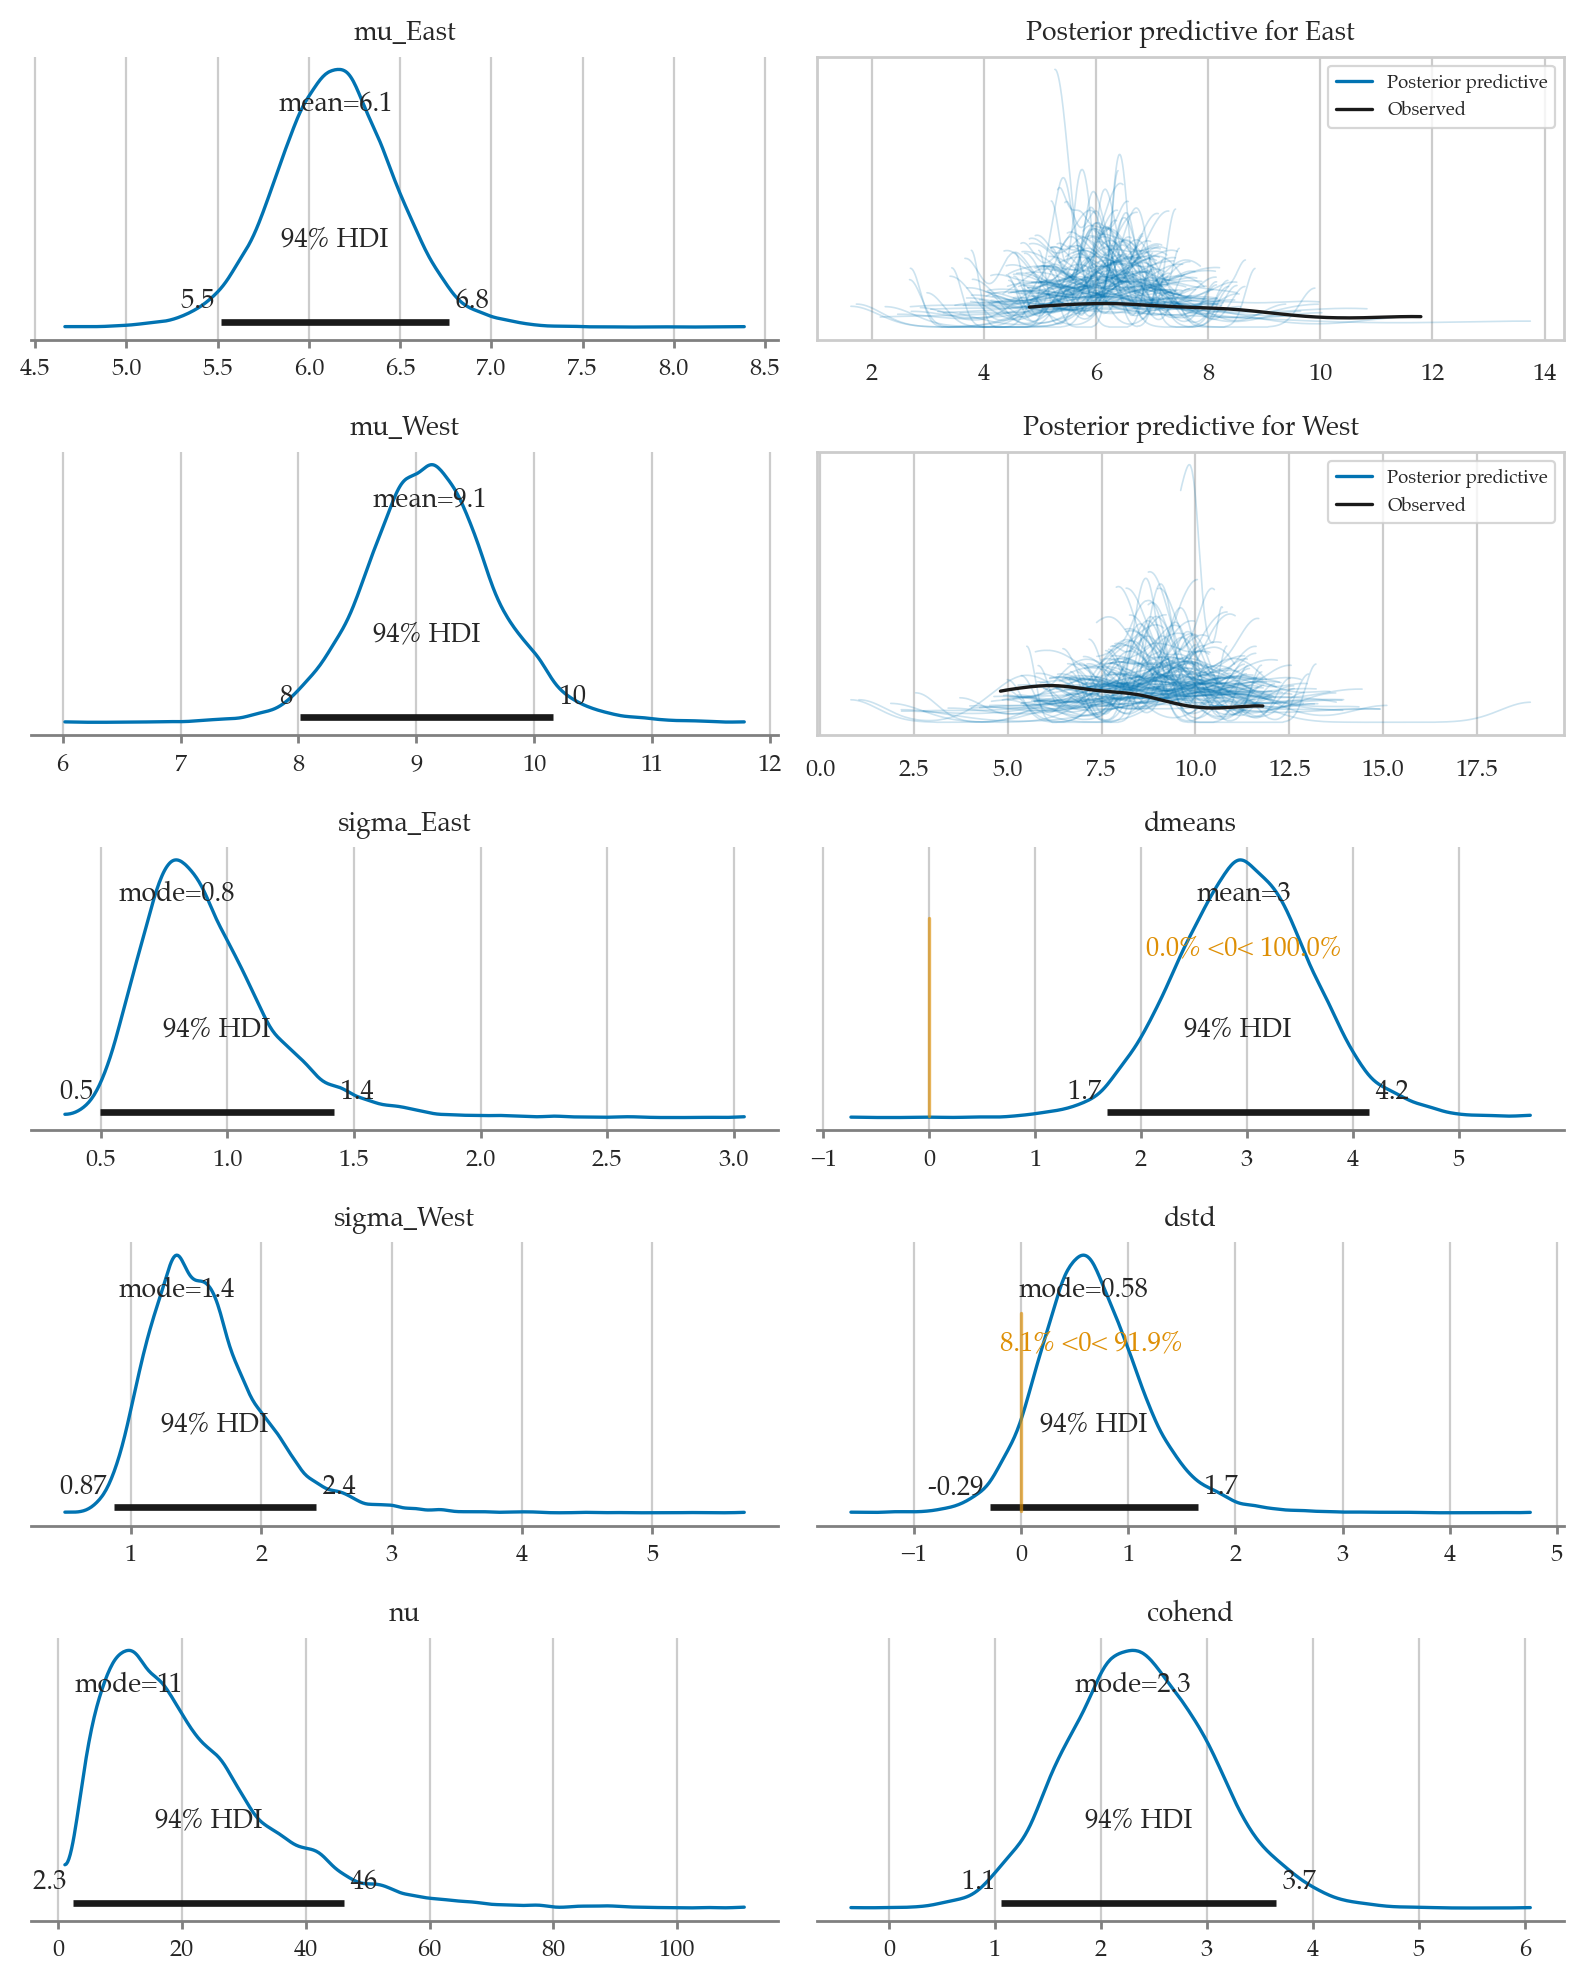

In [7]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod1, idata1, group_name="loc");

## Example 2: comparing IQ scores

We'll look at IQ scores data taken from a the paper *Bayesian Estimation Supersedes the t-Test* (BEST) by John K. Kruschke.

### Data

In [8]:
iqs2 = pd.read_csv("../datasets/iqs2.csv")
iqs2.groupby("group")["iq"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ctrl,42.0,100.357143,2.516496,88.0,100.0,100.5,101.0,105.0
treat,47.0,101.914894,6.021085,82.0,100.0,102.0,103.0,124.0


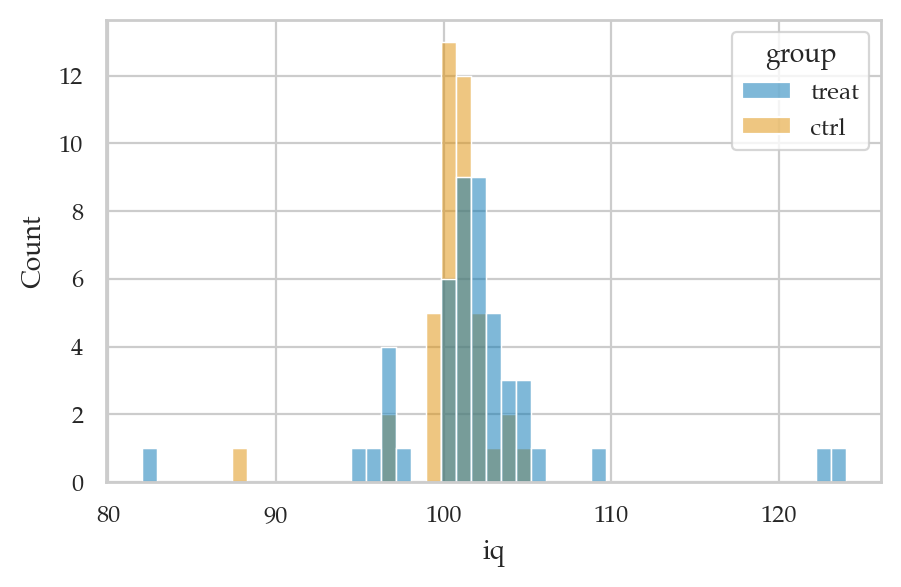

In [9]:
sns.histplot(data=iqs2, x="iq", hue="group");

### Model

In [10]:
formula2 = bmb.Formula("iq ~ 1 + group",
                       "sigma ~ 0 + group")

mod2 = bmb.Model(formula=formula2,
                 family="t",
                 link="identity",
                 data=iqs2)
mod2

       Formula: iq ~ 1 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 101.1798, sigma: 17.17)
            group ~ Normal(mu: 0.0, sigma: 23.6275)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_group ~ Normal(mu: 0.0, sigma: 1.0)

In [11]:
# # ALT use the function
# from ministats.bayes import bayes_dmeans
# treated = iqs2[iqs2["group"]=="treat"]["iq"].values
# controls = iqs2[iqs2["group"]=="ctrl"]["iq"].values
# mod2, idata2 = bayes_dmeans(treated, controls, var_name="iq",
#                             group_name="group", groups=["treat", "ctrl"])

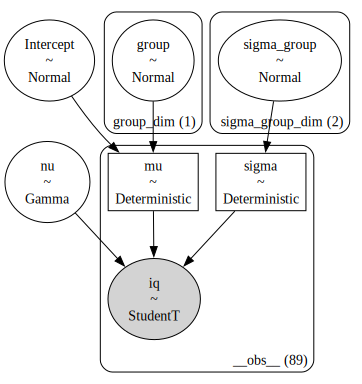

In [12]:
mod2.build()
mod2.graph()

In [13]:
idata2 = mod2.fit(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.


In [14]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata2, group_name="group");
az.summary(idata2, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_treat", "sigma_ctrl", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,1.025,0.425,0.185,1.865
sigma_treat,1.940,0.406,1.203,2.755
sigma_ctrl,1.012,0.196,0.650,1.403
dstd,0.928,0.414,0.136,1.740
nu,1.811,0.474,1.031,2.755
cohend,0.682,0.306,0.087,1.284


In [15]:
# ALT. manual calculations
# post2 = idata2["posterior"]
# # Calculate sigmas from log-sigmas
# post2["sigma_treat"] = np.exp(post2["sigma_group"][:,:,1])
# post2["sigma_ctrl"] = np.exp(post2["sigma_group"][:,:,0])
# # Difference in standard deviations
# post2["dstd"] = post2["sigma_treat"] - post2["sigma_ctrl"]

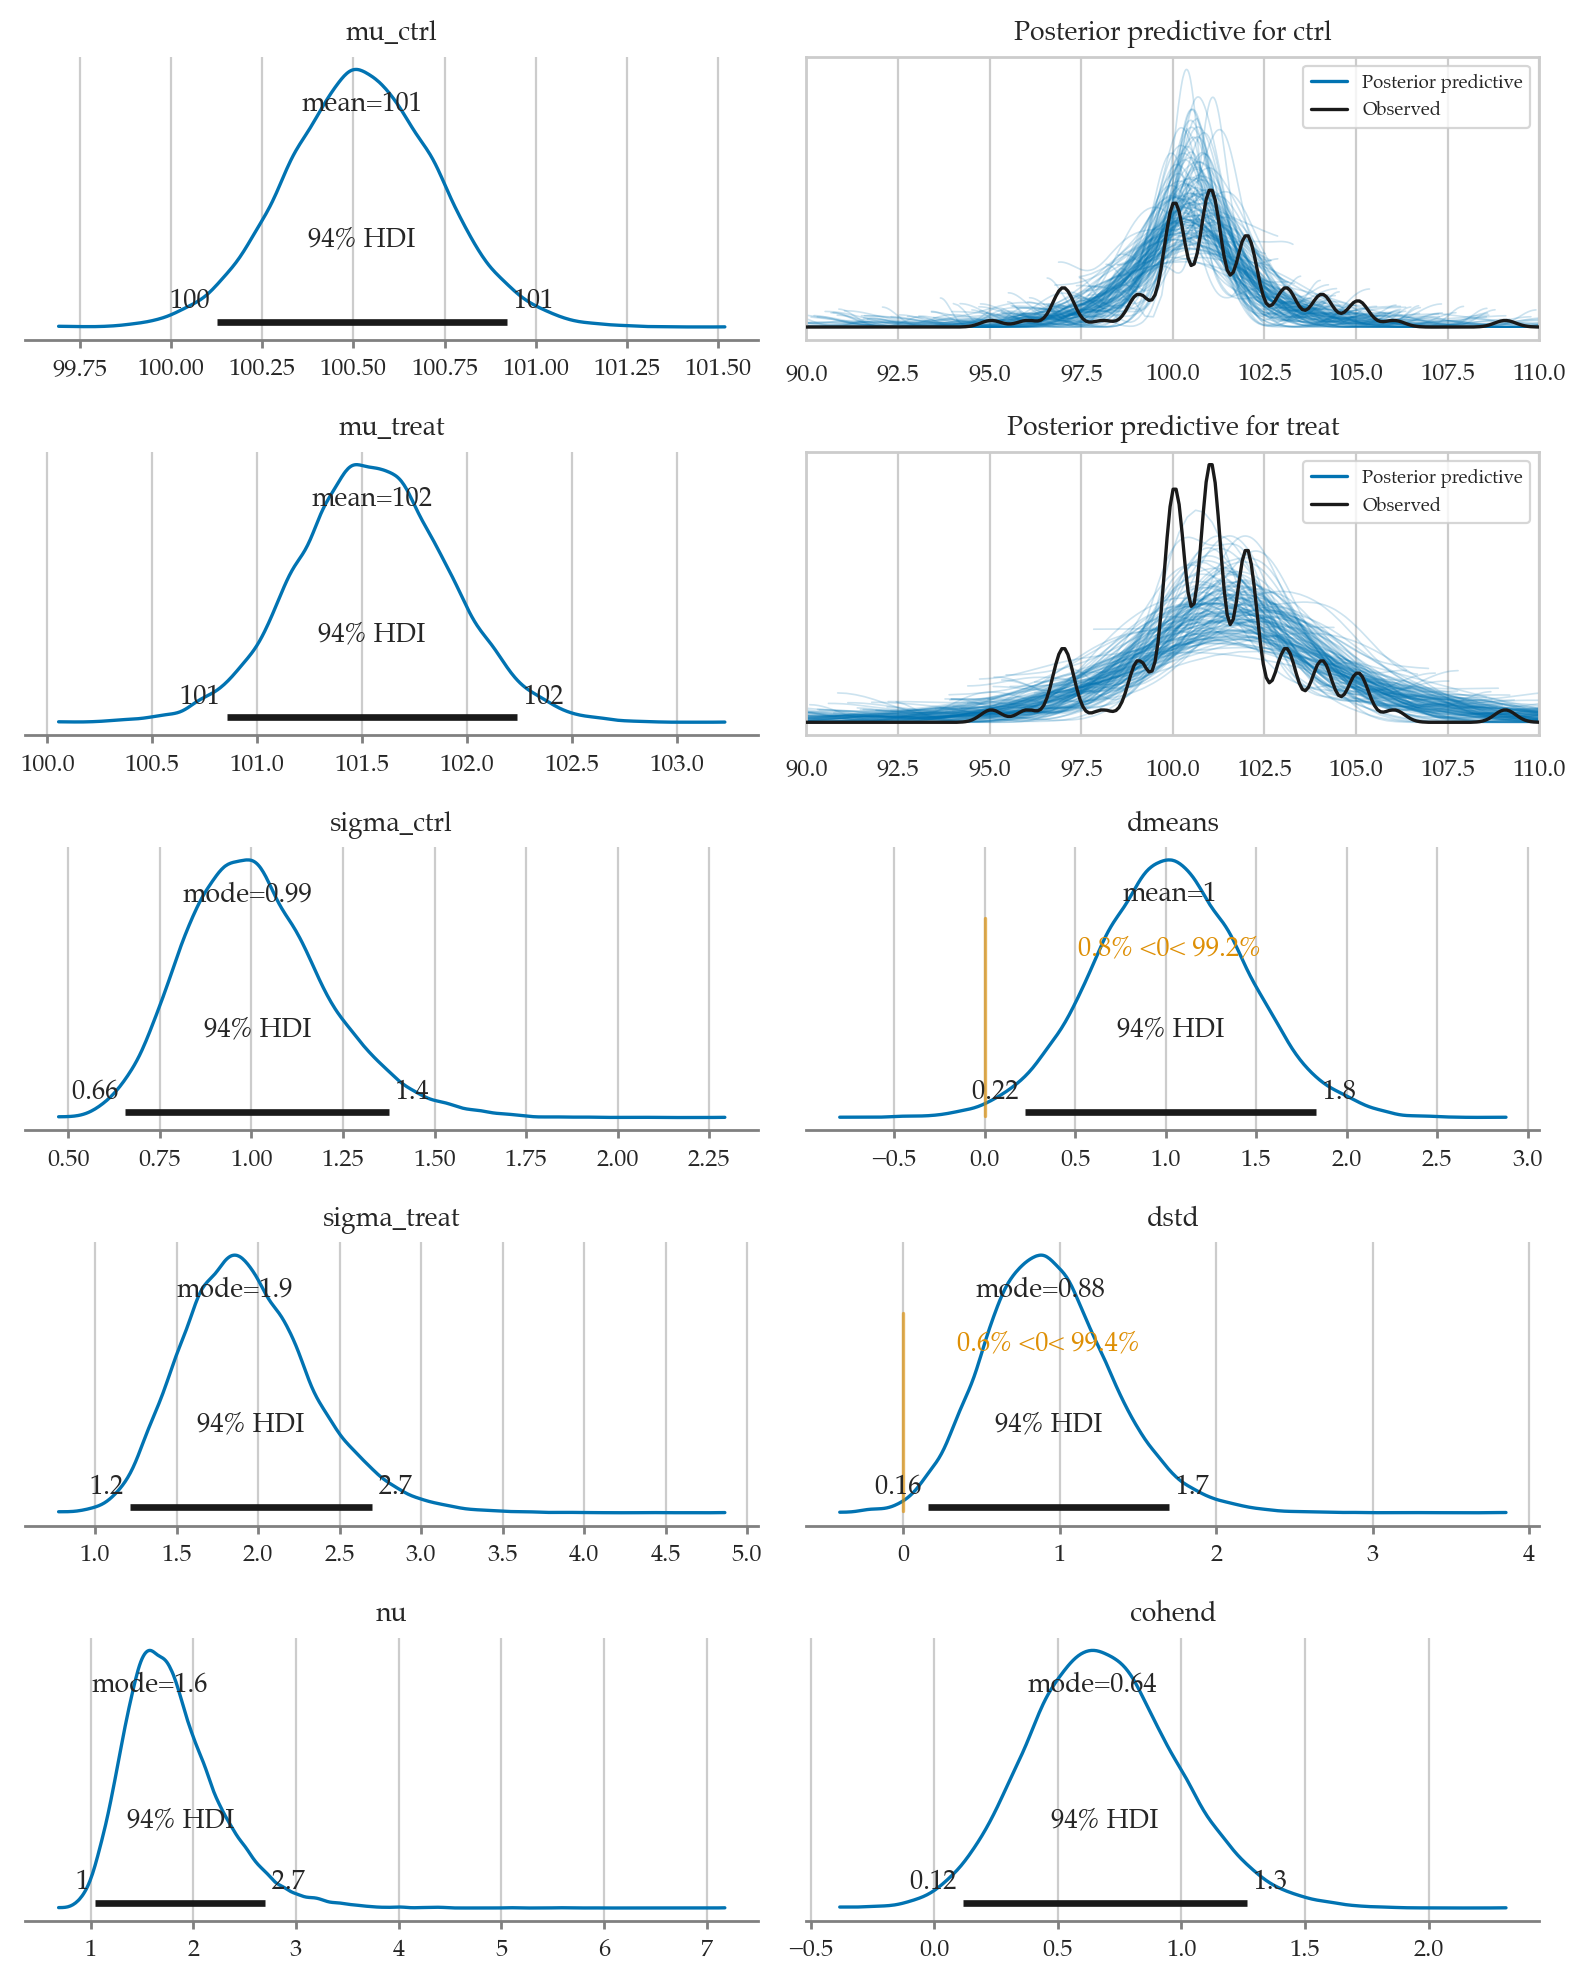

In [16]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod2, idata2, group_name="group", ppc_xlims=[90,110]);

## Example 3: lecture and debate curriculums


### Data

In [17]:
students = pd.read_csv("../datasets/students.csv")
students.groupby("curriculum")["score"].describe()

,count,mean,std,min,25%,50%,75%,max
curriculum,,,,,,,,
debate,8.0,76.462500,10.519633,62.9,69.55,75.55,80.925,96.2
lecture,7.0,68.142857,7.758406,57.0,63.30,70.30,73.850,75.4


In [18]:
from ministats.bayes import bayes_dmeans

studentsD = students[students["curriculum"]=="debate"]
studentsL = students[students["curriculum"]=="lecture"]
scoresD = studentsD["score"]
scoresL = studentsL["score"]

mod3, idata3 = bayes_dmeans(scoresD, scoresL, group_name="curriculum", var_name="score", groups=["debate", "lecture"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, curriculum, sigma_curriculum]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


In [19]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata3, group_name="curriculum");
az.summary(idata3, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_debate", "sigma_lecture", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-6.924,4.734,-16.039,2.529
sigma_debate,8.771,2.718,3.469,14.202
sigma_lecture,6.618,2.221,2.534,11.233
dstd,-2.153,3.269,-8.866,4.312
nu,17.232,13.782,0.696,44.301
cohend,-0.904,0.619,-2.090,0.316


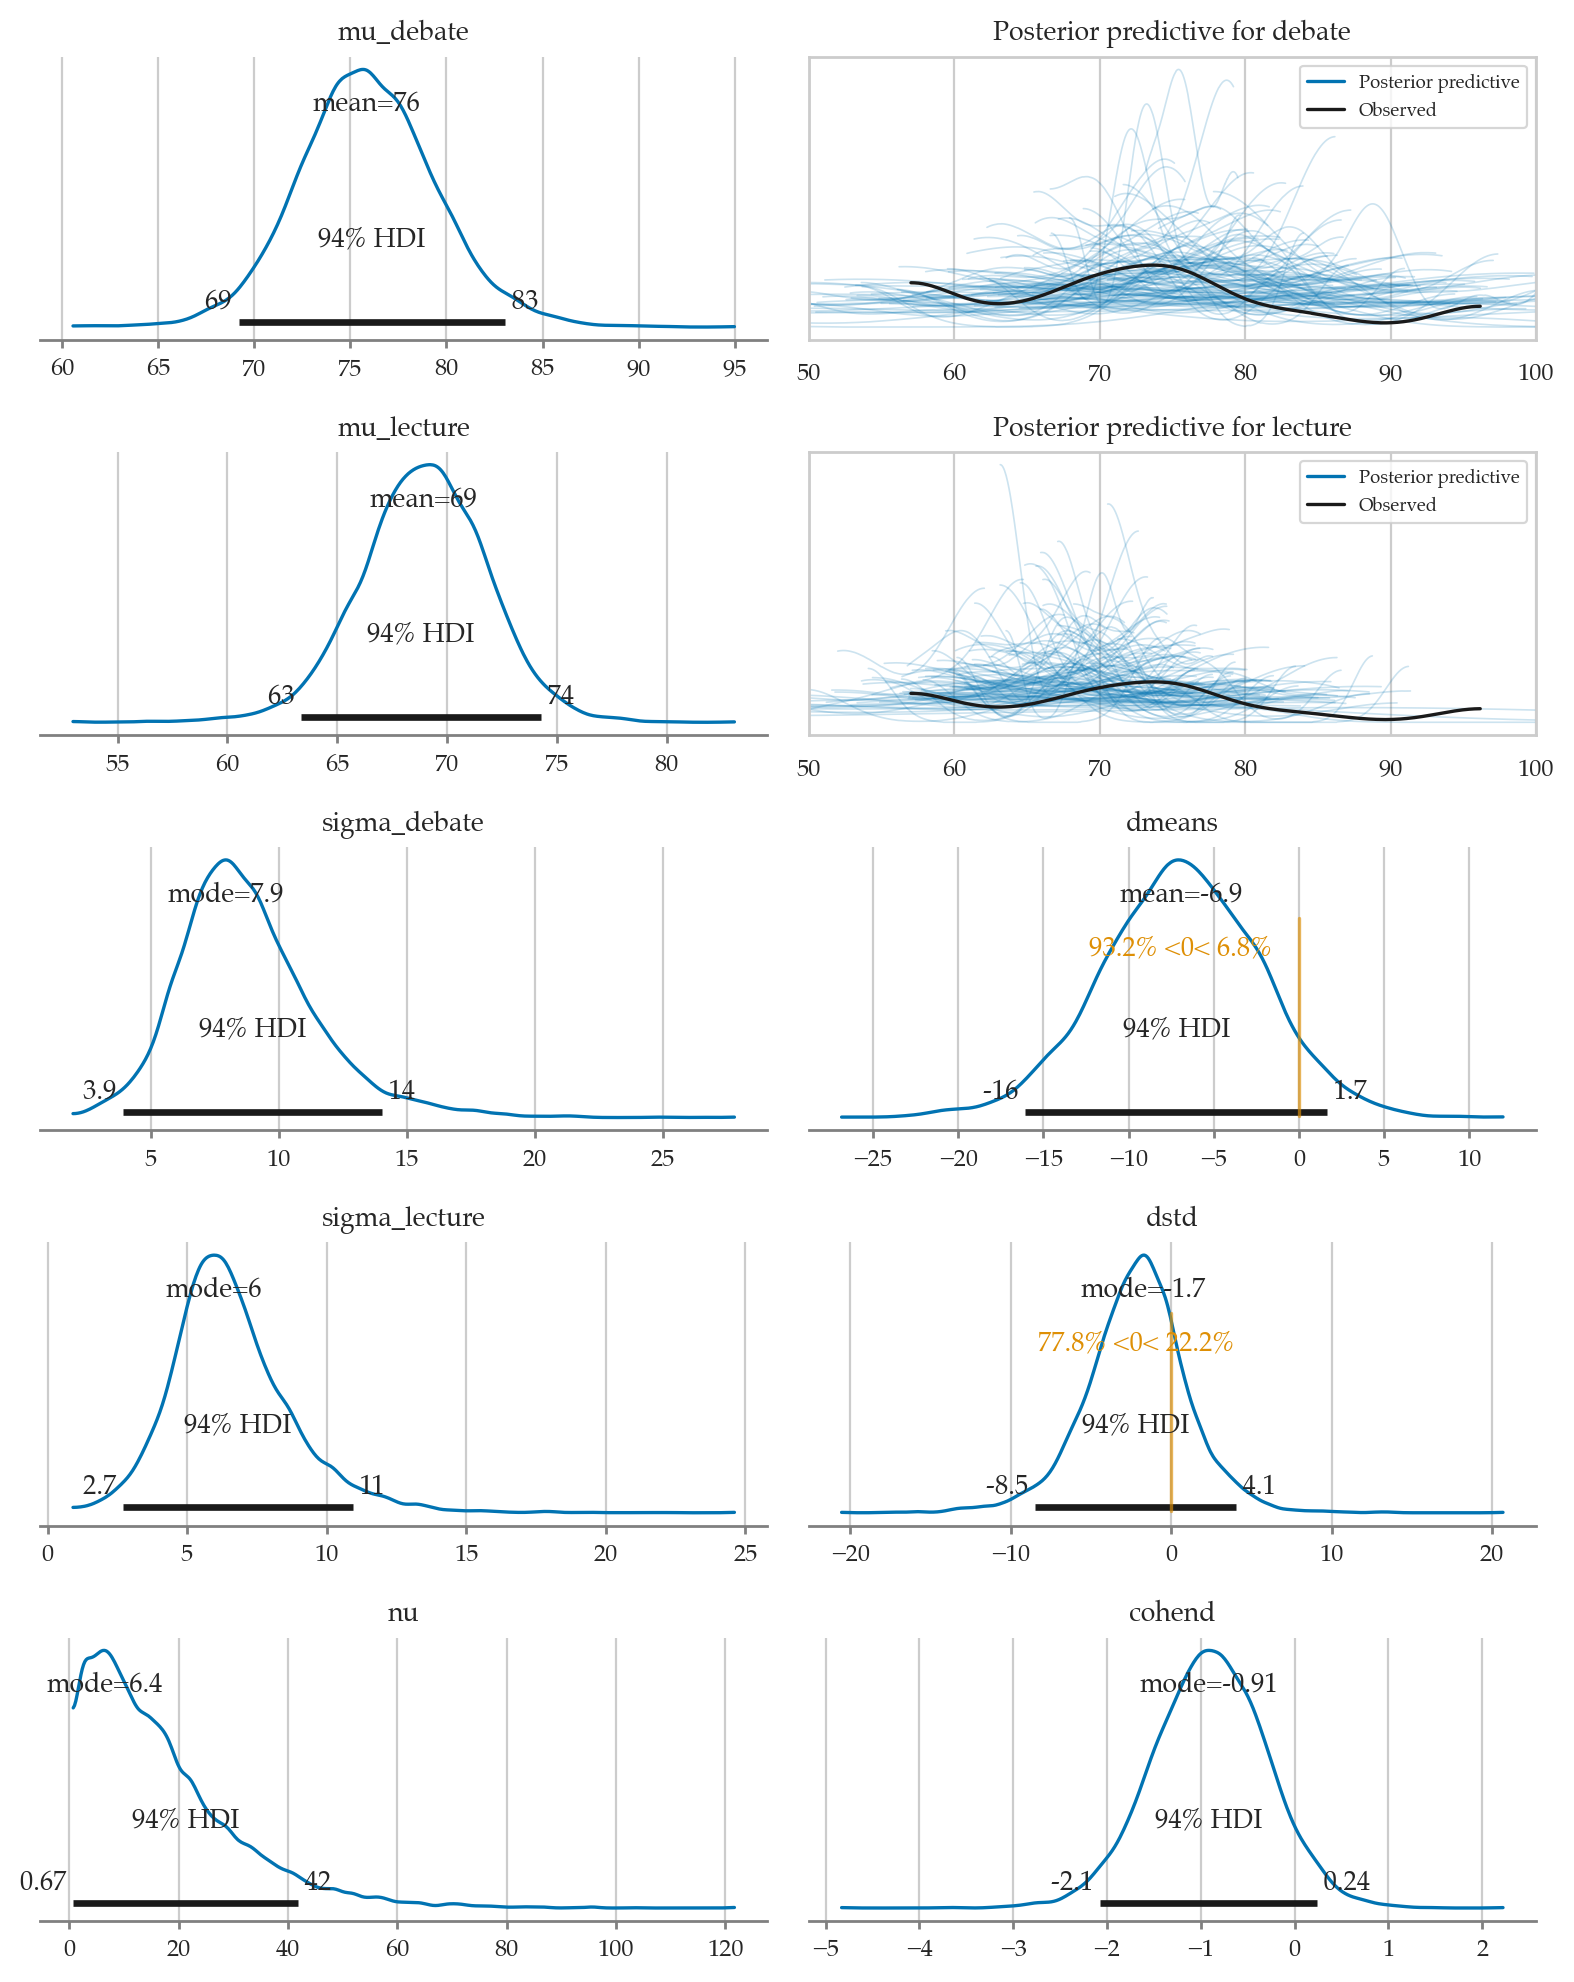

In [20]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod3, idata3, group_name="curriculum", ppc_xlims=[50,100]);

## Example 4: small example form BEST vignette

See http://cran.nexr.com/web/packages/BEST/vignettes/BEST.pdf#page=2


In [21]:
y1s = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
y2s = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]

from ministats.bayes import bayes_dmeans
mod4, idata4 = bayes_dmeans(y1s, y2s, groups=["y1", "y2"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


In [22]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata4)
az.summary(idata4, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_y1", "sigma_y2", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-1.459,0.494,-2.465,-0.471
sigma_y1,0.857,0.347,0.371,1.506
sigma_y2,0.724,0.290,0.324,1.308
dstd,-0.133,0.454,-1.011,0.747
nu,21.412,14.169,1.410,49.524
cohend,-1.923,0.772,-3.452,-0.419


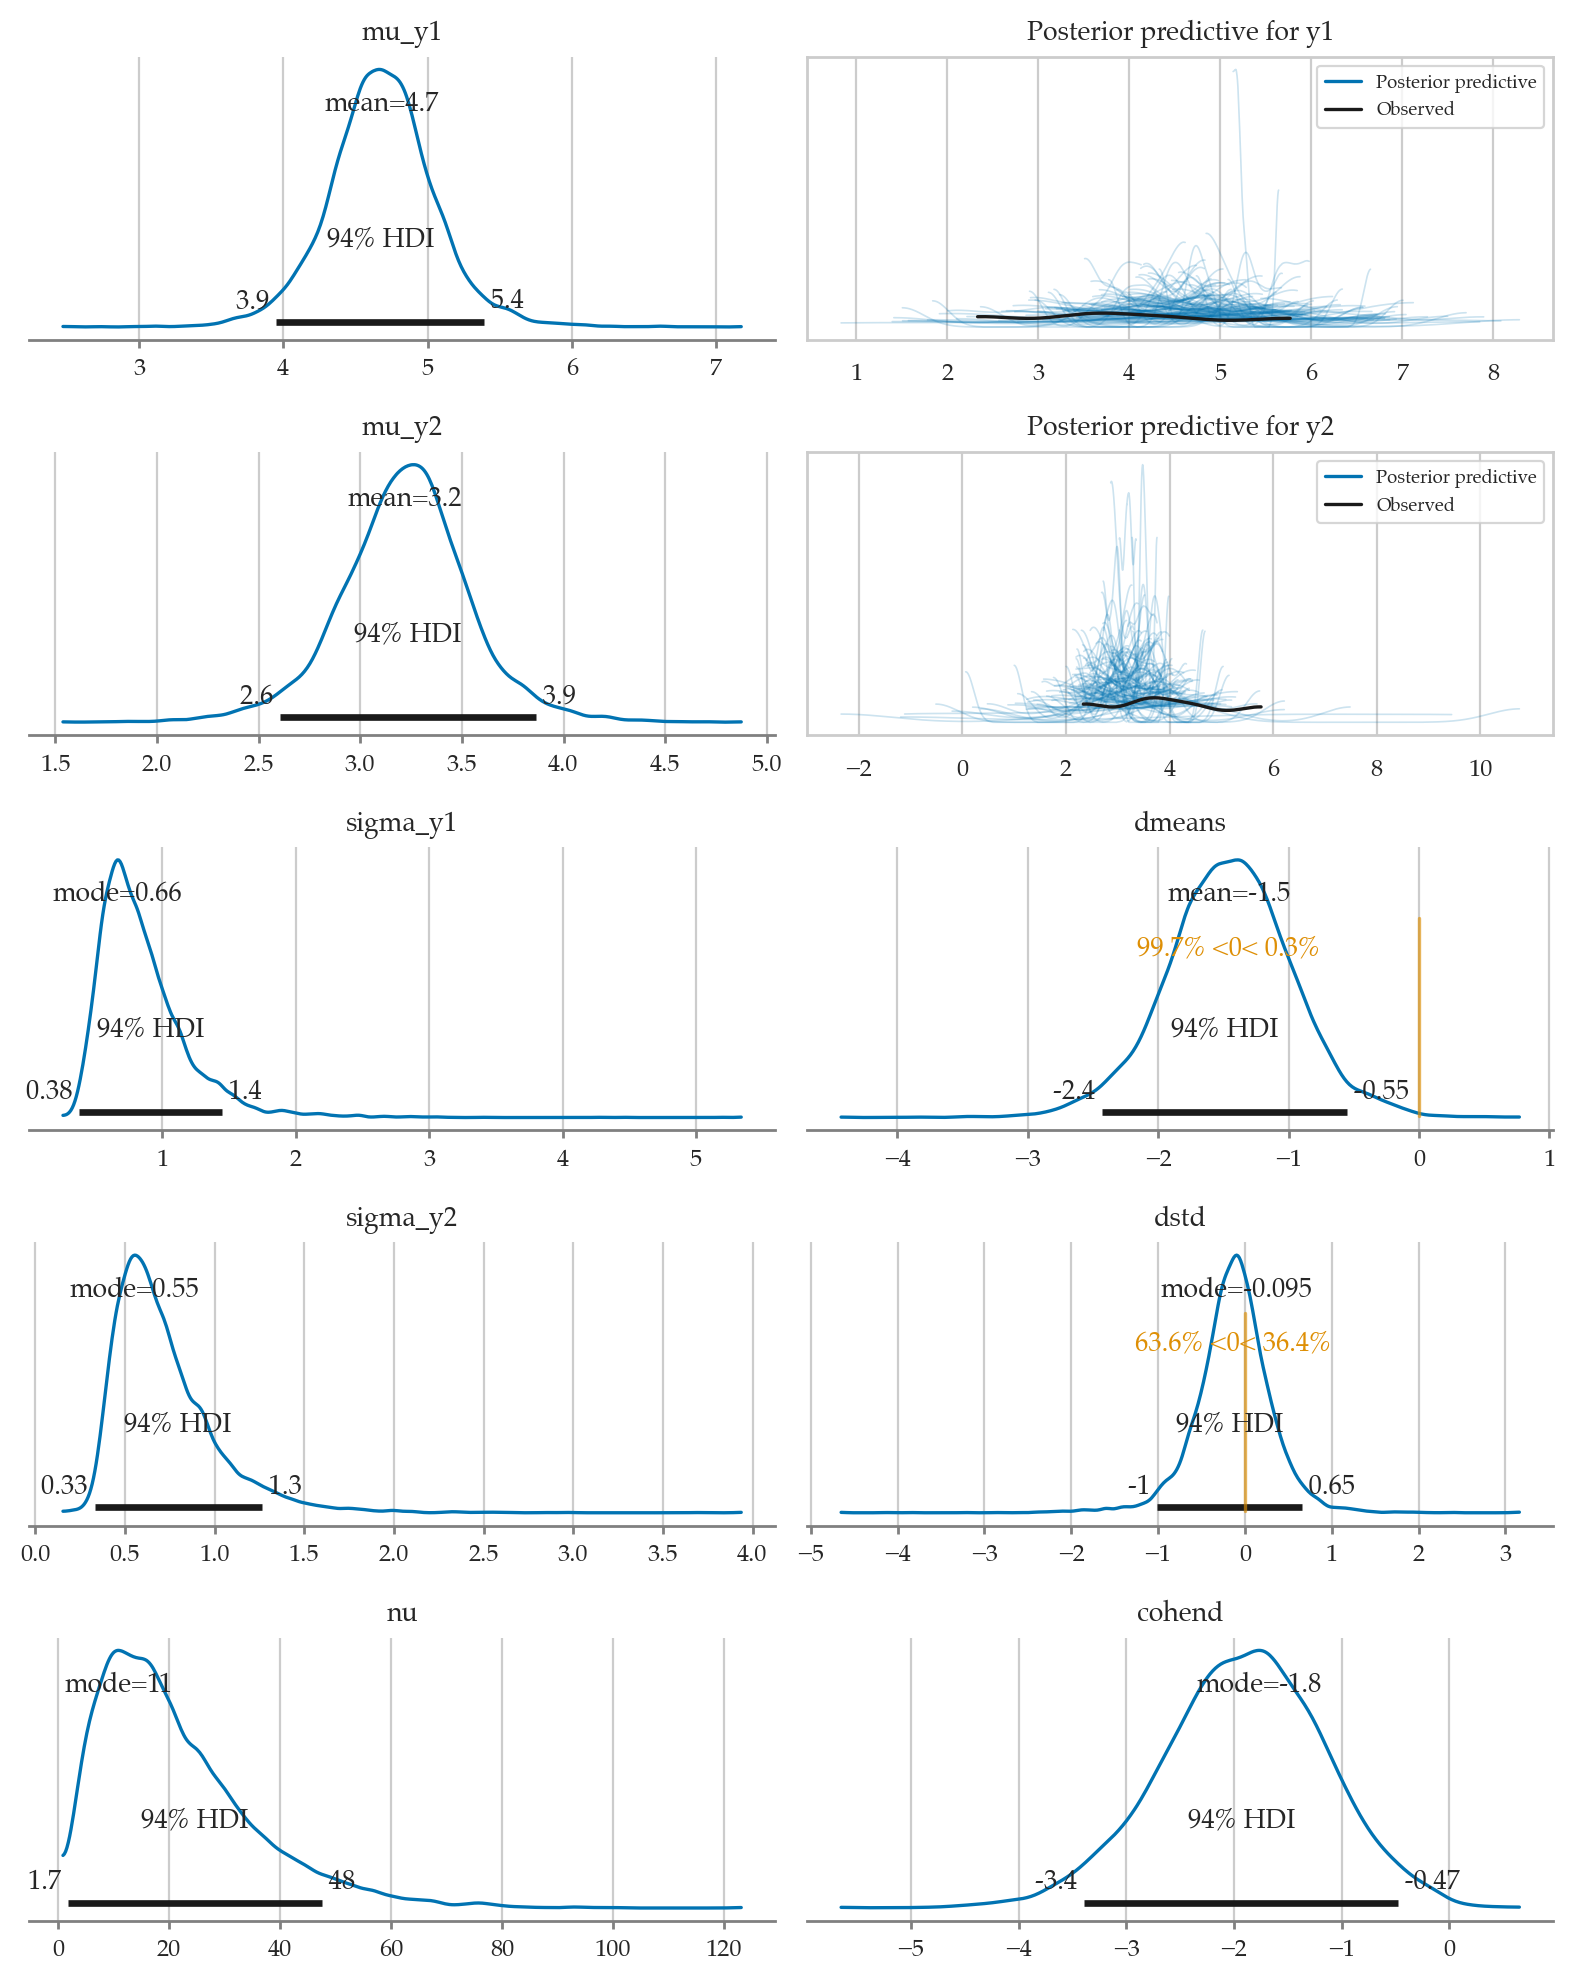

In [23]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod4, idata4, ppc_xlims=None);

## Example 5: comparing morning to evening

https://github.com/treszkai/best/blob/master/examples/paired_samples.py


In [24]:
morning = [8.99, 9.21, 9.03, 9.15, 8.68, 8.82, 8.66, 8.82, 8.59, 8.14,
           9.09, 8.80, 8.18, 9.23, 8.55, 9.03, 9.36, 9.06, 9.57, 8.38]
evening = [9.82, 9.34, 9.73, 9.93, 9.33, 9.41, 9.48, 9.14, 8.62, 8.60,
           9.60, 9.41, 8.43, 9.77, 8.96, 9.81, 9.75, 9.50, 9.90, 9.13]

In [25]:
from ministats.bayes import bayes_dmeans
mod5, idata5 = bayes_dmeans(evening, morning, groups=["evening", "morning"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


In [26]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata5)
az.summary(idata5, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_evening", "sigma_morning", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-0.526,0.143,-0.806,-0.246
sigma_evening,0.456,0.087,0.297,0.627
sigma_morning,0.387,0.071,0.259,0.530
dstd,-0.068,0.110,-0.290,0.148
nu,23.141,14.188,2.845,51.255
cohend,-1.261,0.386,-2.047,-0.530


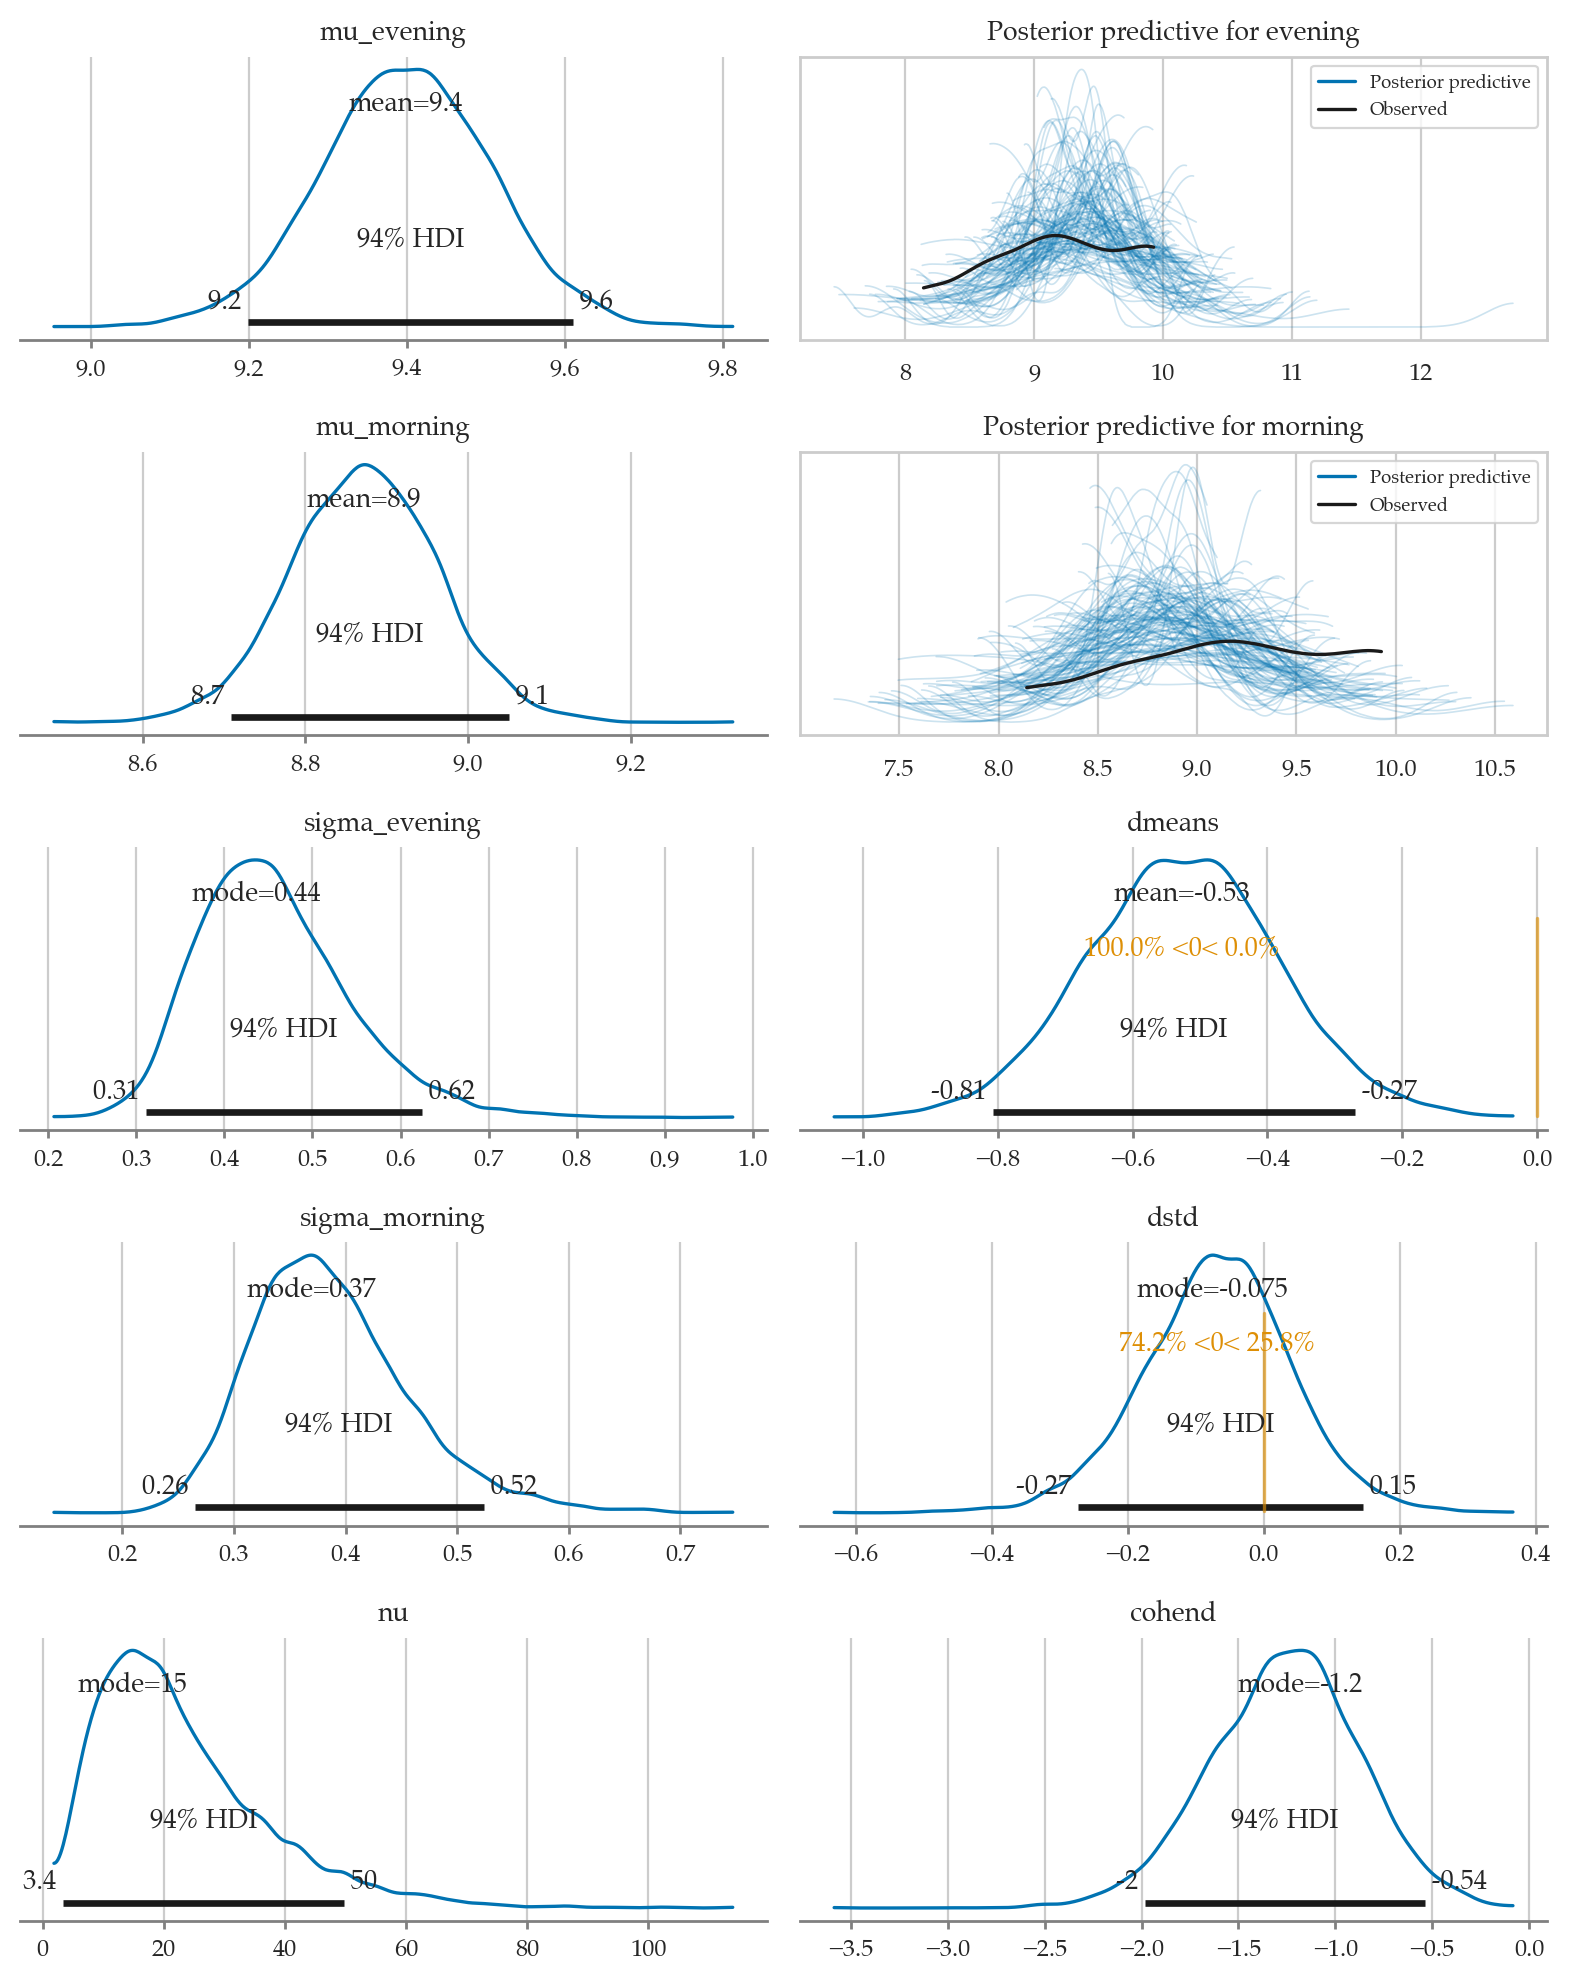

In [27]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod5, idata5, ppc_xlims=None);

## Explanations

## Discussion

## Exercises

### Exercise 1: small samples

In [28]:
As = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
Bs = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]
groups = ["A"]*len(As) + ["B"]*len(Bs)
df1 = pd.DataFrame({"group": groups, "vals": As + Bs})
# df1

In [29]:
from scipy.stats import t as tdist

tdist(loc=100, scale=10, df=2.1).std()

45.82575694955838

In [30]:
10 * np.sqrt(2.1 / (2.1-2))

45.82575694955838

alpha=1.0 beta=0.03333333333333333


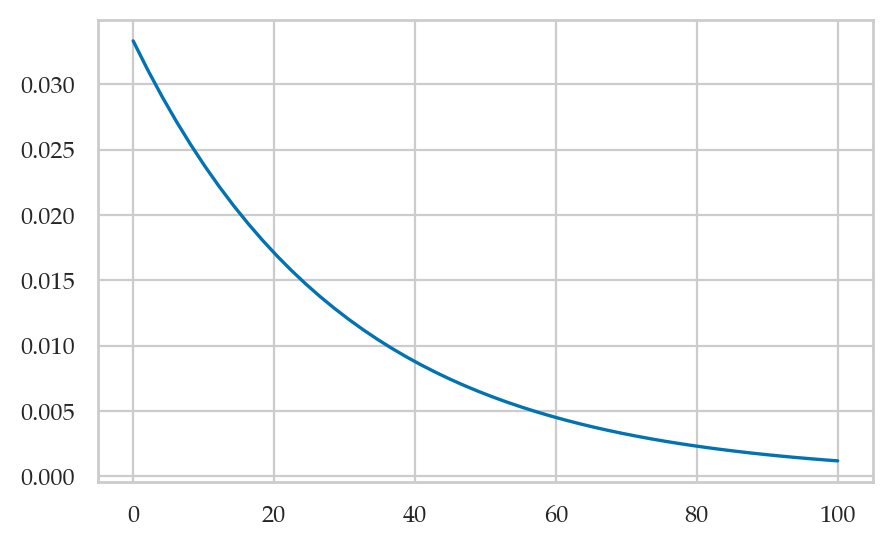

In [31]:
# New Default prior in R BEST code
from scipy.stats import gamma

nuMean = 30
nuSD = 30

alpha = nuMean**2 / nuSD**2  # shape
beta = nuMean / nuSD**2   # rate
print(f"{alpha=} {beta=}")

rv_Nu = gamma(a=alpha, scale=1/beta)
xs = np.linspace(0,100)
ax = sns.lineplot(x=xs, y=rv_Nu.pdf(xs));

<Axes: >

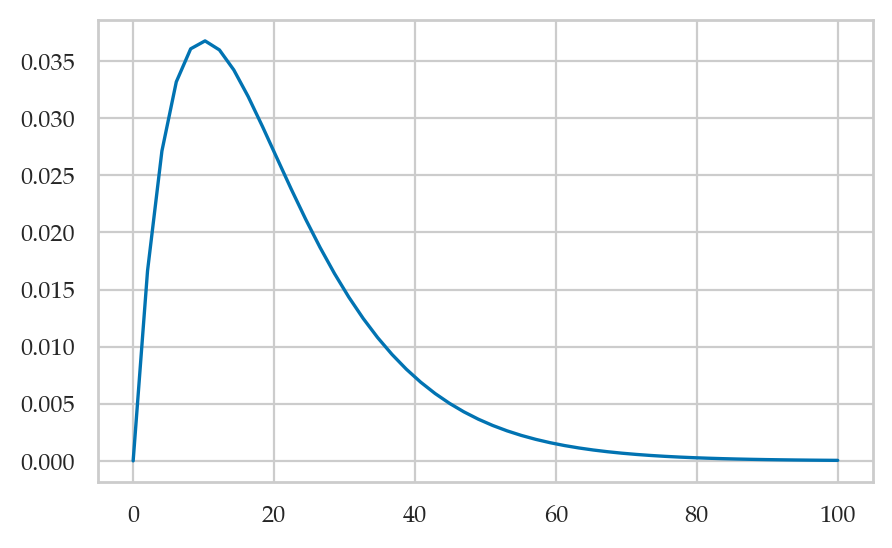

In [32]:
# Bambi default prior for `nu`
rv_Nu2 = gamma(a=2, scale=10)
xs = np.linspace(0,100)
sns.lineplot(x=xs, y=rv_Nu2.pdf(xs))

## Links